In [1]:
import numpy as np
import cv2
from tqdm import tqdm_notebook
import os, os.path
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Images path and names
img_path = './columbia_edu_images/'
img_names = os.listdir(img_path)

Let's look at data

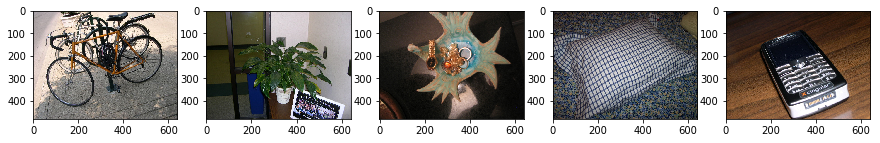

In [3]:

size_sm = 5
fig, axes = plt.subplots(1, size_sm)
fig.set_size_inches((15,15))

i = 0
for img_name in img_names[0:size_sm]:
    img = cv2.imread(f"{img_path}/{img_name}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    i+=1
plt.show()

## 1.
Get histogram for all images

In [4]:
# max pixel value
df = pd.DataFrame(columns=["Img", "Gray", "Red", "Green", "Blue"])
max_p_v = 256
for img_name in img_names:
    img = cv2.imread(f"{img_path}/{img_name}")
    # I prefer RGB format.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # histogram for each color
    r_hist = cv2.calcHist([img],[0],None,[max_p_v],[0,max_p_v]).flatten()
    g_hist = cv2.calcHist([img],[1],None,[max_p_v],[0,max_p_v]).flatten()
    b_hist = cv2.calcHist([img],[2],None,[max_p_v],[0,max_p_v]).flatten()
    # gray histogram
    gray_hist = cv2.calcHist([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)],[0],None,[max_p_v],[0,max_p_v]).flatten()
    
    df.loc[len(df)] = [ img_name, gray_hist, r_hist, g_hist, b_hist ]

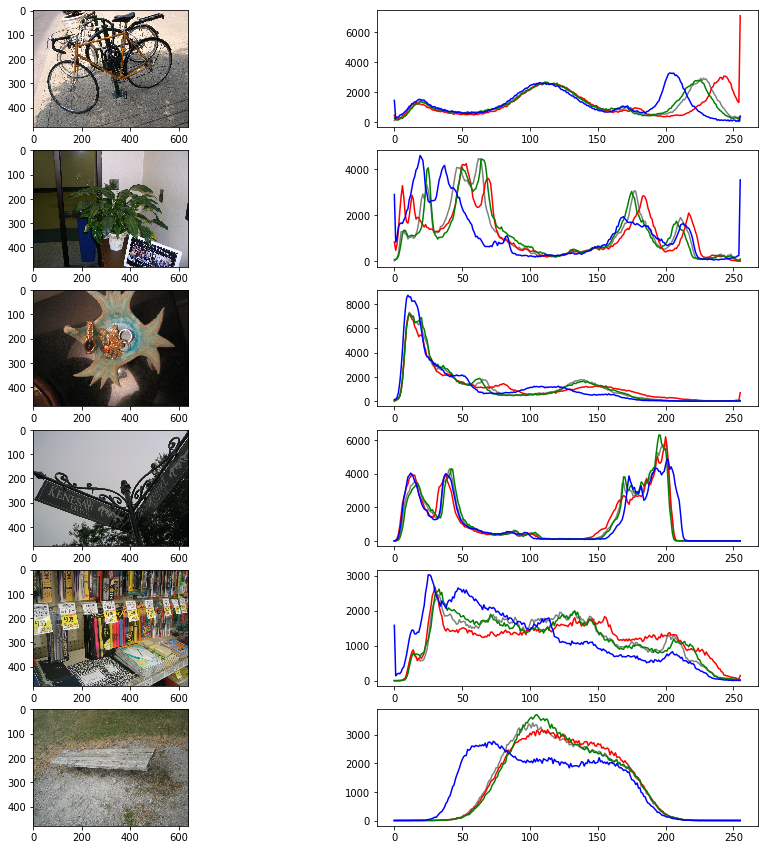

In [5]:
# count of image histogram to display
indexes = [0,1,2,20,21,22]
fig, axes = plt.subplots(len(indexes),2)
fig.set_size_inches((15,15))

ax_i = 0
for i in indexes:
    img_ax, hist_ax = axes[ax_i]
    
    img = cv2.imread(f"{img_path}/{img_names[i]}")
    # display img
    img_ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # deplay color histogram
    hist_ax.plot(df.iloc[i,1], "gray")
    hist_ax.plot(df.iloc[i,2], "red")
    hist_ax.plot(df.iloc[i,3], "green")
    hist_ax.plot(df.iloc[i,4], "blue")
    ax_i+=1

As we can see, similiar images have similiar histograms.

## 2
Measure $L_2$ distance

In [6]:
# Square difference between corresponding histograms
def measureL2(img1, img2):
    result = sum([sum((h1-h2)**2) for h1, h2 in zip(img1,img2)])
    return np.sqrt(result)

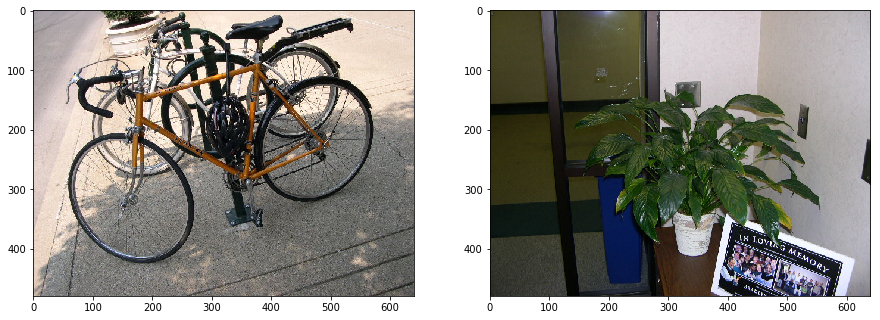

L_2 Difference = 42853.67154632144


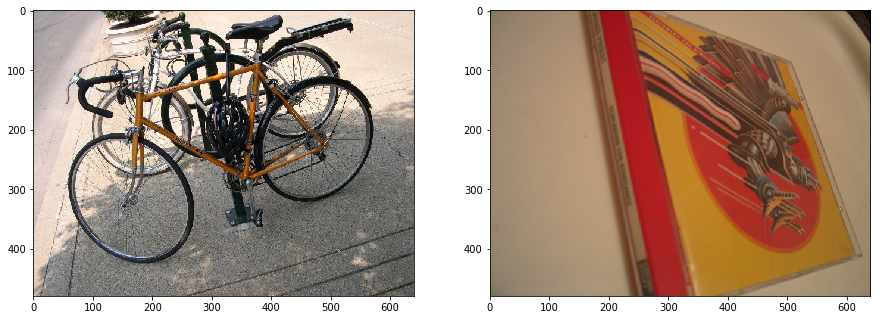

L_2 Difference = 59507.32081013226


In [7]:
indexes = [[0,1], [0,200]]

ax_i = 0
for pair in indexes:
    # Create axes
    fig, axes = plt.subplots(1,2)
    fig.set_size_inches((15,15))
    img1_ax, img2_ax = axes
    # index of images to compare
    i_1, i_2 = pair
    # read images
    img1 = cv2.imread(f"{img_path}/{img_names[i_1]}")
    img2 = cv2.imread(f"{img_path}/{img_names[i_2]}")
    # show images
    img1_ax.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    img2_ax.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    
    # measure distance between images histograms
    l_2 = measureL2(
        [df.iloc[i_1,2], df.iloc[i_1,3], df.iloc[i_1,4]],
        [df.iloc[i_2,2], df.iloc[i_2,3], df.iloc[i_2,4]],
    )
    plt.show()
    print(f"L_2 Difference = {l_2}")
    
    ax_i+=1

As we see the distance between siliar images is much closer. So the calculations are right.

## 3.

In [8]:
test_names = ['ukbench00004.jpg', 'ukbench00040.jpg', 'ukbench00060.jpg', 'ukbench00588.jpg', 'ukbench01562.jpg']

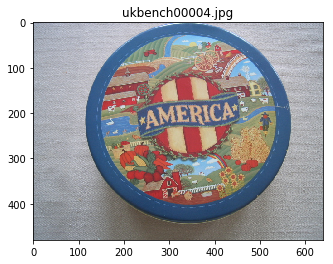

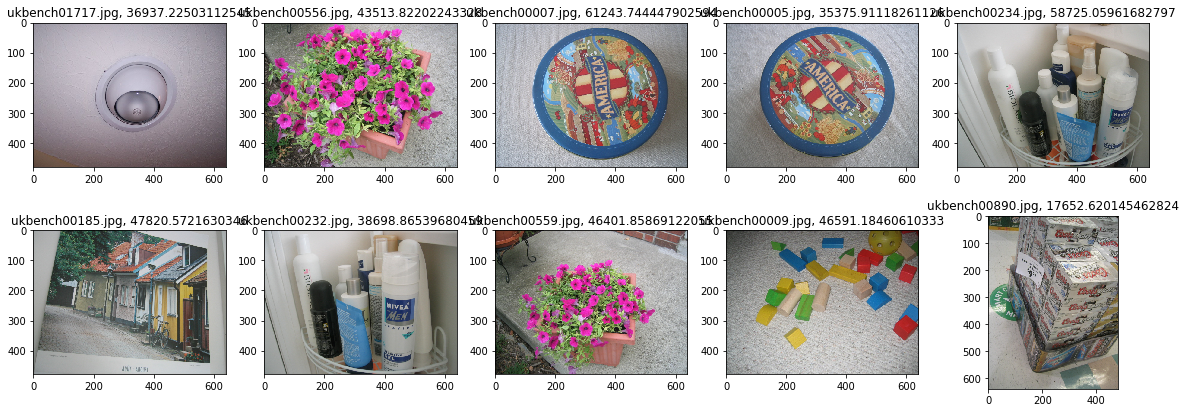

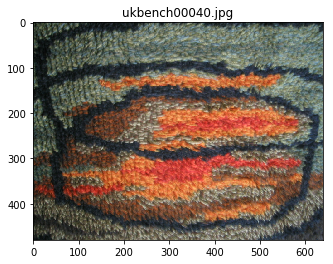

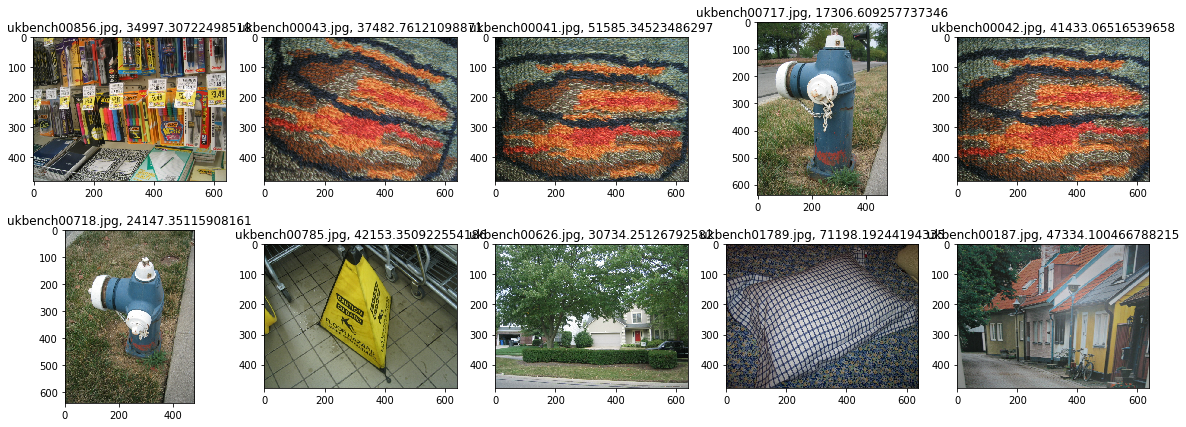

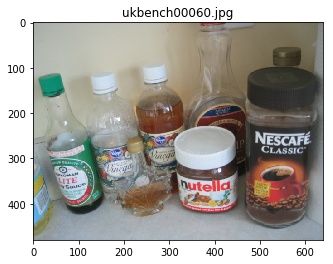

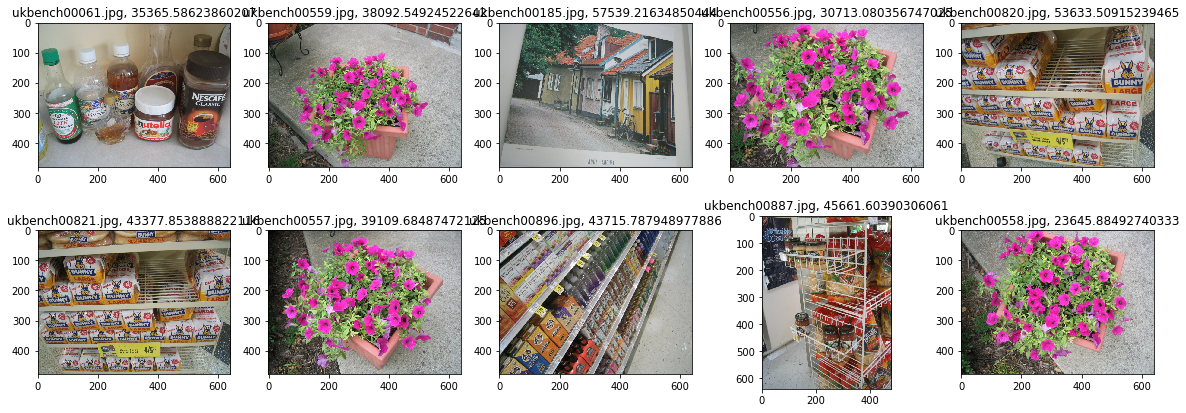

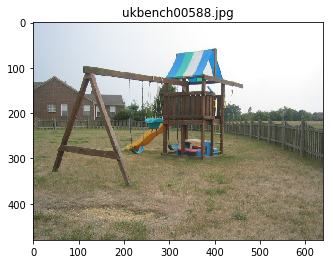

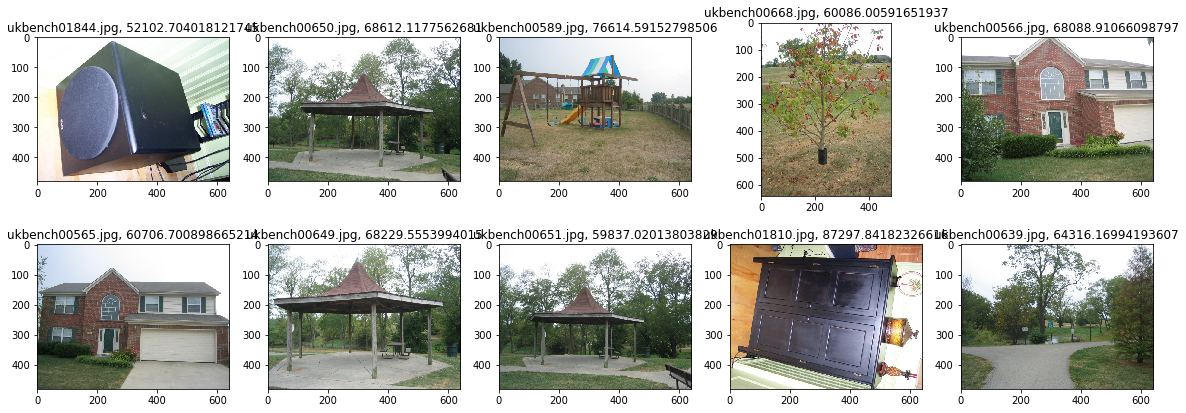

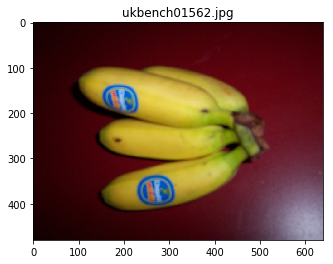

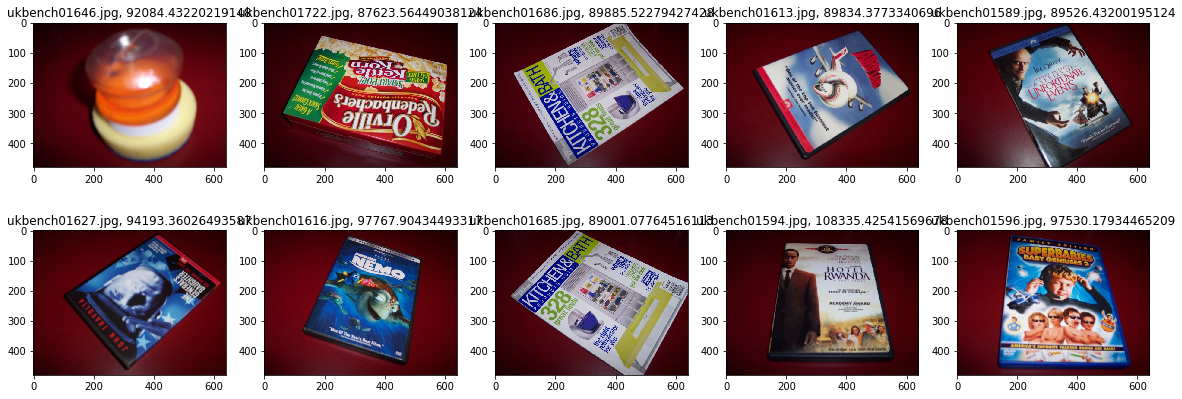

In [9]:
# function for getting histograms by index
getHists = lambda i: [df.iloc[i,2], df.iloc[i,3], df.iloc[i,4]]
# how many closest images to find
n_closest = 10

for test_name in test_names:
    # get index by image name
    test_index = img_names.index(test_name)
    # load image
    img = cv2.imread(f"{img_path}/{img_names[test_index]}")
    # get histograms of image
    test_hists = getHists(test_index)
    # measure distances between all images
    distances = [measureL2(test_hists, getHists(i)) for i in range(len(df))]
    # set distance with the same image to the max value.
    # We know that the closes distance would be to the same omage, of course.
    distances[test_index] = max(distances)
    # get indexes of the closes images
    min_indexes = np.argpartition(distances, n_closest)[:n_closest]
    
    # display actuall image
    plt.title(img_names[test_index])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    # display closest ones
    fig, axes = plt.subplots(2,5)
    fig.set_size_inches((20,7))
    for i in range(10):
        min_index = min_indexes[i]
        closest_image = cv2.imread(f"{img_path}/{img_names[min_index]}")
        ax = axes[i // 5, i % 5]
        ax.set_title(f"{img_names[min_index]}, {distances[i]}")
        ax.imshow(cv2.cvtColor(closest_image, cv2.COLOR_BGR2RGB))
    plt.show()
    

## 4.

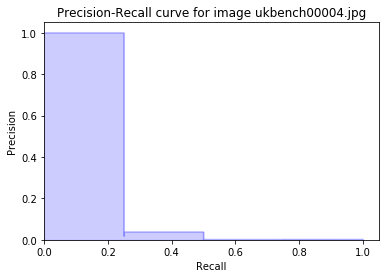

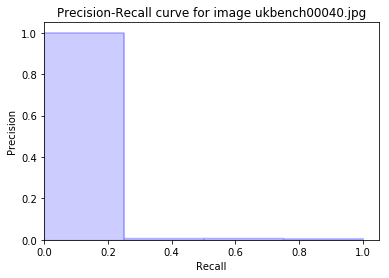

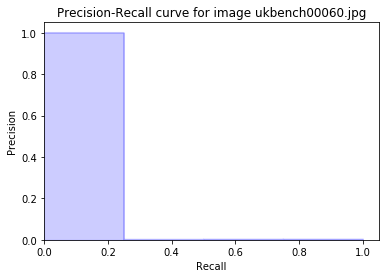

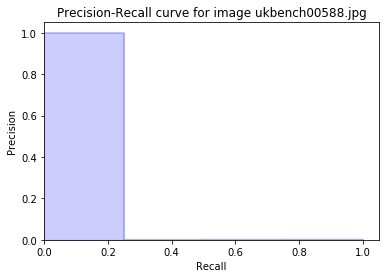

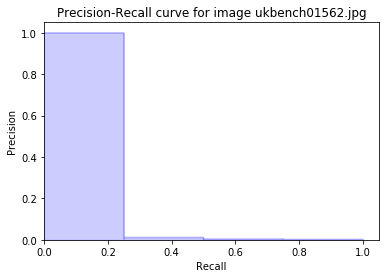

In [10]:
from sklearn.metrics import precision_recall_curve

# We will assume that images around radius 2 (prev 2 and next 2) are the same.
radius_close = 2
# go through above images
for img_name in test_names:
    # get image index and histogram
    img_index = img_names.index(img_name)
    img_hist = getHists(img_index)

    images_l = len(img_names)
    
    # set all lables to 0
    labels = np.zeros(images_l)
    # set actual image label and images in radius to 1 as target ones
    labels[img_index-radius_close:img_index+radius_close] = 1
    # measure dinstacnes between image histogram and all other histograms
    distances = np.array([measureL2(img_hist, getHists(i)) for i in range(len(img_names))])
    # normilize
    norm_distances = distances/distances.max()
    # invert as smallest distance mean more propability to be target
    inv_distances = 1-norm_distances
    # get R curve
    pr, rec, _ = precision_recall_curve(labels, inv_distances)
    # PLOT R curve
    plt.step(rec, pr, color='b', alpha=0.2, where='post')
    plt.fill_between(rec, pr, alpha=0.2, color='b', step='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')

    plt.ylim([0.00, 1.05])
    plt.xlim([0.00, 1.05])

    plt.title(f'Precision-Recall curve for image {img_name}')
    plt.show()